<a href="https://colab.research.google.com/github/hardyjeremy98/FloodNet/blob/main/FloodNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

In [69]:
# Import PyTorch
import torch
import torch.nn as nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [71]:
input_channels = 3
num_classes = 10

---
# Getting data

In [72]:
# !cp -r /content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data /content/local_dataset-floodnet

In [73]:
# data_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data'
# train_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train'

# train_image_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train/train-org-img'
# train_mask_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train/train-label-img'

In [74]:
data_folder = r'/content/local_dataset-floodnet'
train_folder = r'/content/local_dataset-floodnet/train'

train_image_folder = r'/content/local_dataset-floodnet/train/train-org-img'
train_mask_folder = r'/content/local_dataset-floodnet/train/train-label-img'

In [75]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files/images in {dirpath}")

In [76]:
walk_through_dir(data_folder)

There are 3 directories and 1 files/images in /content/local_dataset-floodnet
There are 2 directories and 0 files/images in /content/local_dataset-floodnet/train
There are 0 directories and 1445 files/images in /content/local_dataset-floodnet/train/train-label-img
There are 0 directories and 1445 files/images in /content/local_dataset-floodnet/train/train-org-img
There are 2 directories and 0 files/images in /content/local_dataset-floodnet/test
There are 0 directories and 448 files/images in /content/local_dataset-floodnet/test/test-label-img
There are 0 directories and 448 files/images in /content/local_dataset-floodnet/test/test-org-img
There are 2 directories and 0 files/images in /content/local_dataset-floodnet/val
There are 0 directories and 450 files/images in /content/local_dataset-floodnet/val/val-label-img
There are 0 directories and 450 files/images in /content/local_dataset-floodnet/val/val-org-img


In [77]:
# prompt: Write code for a function that will plot a random image from the folder given

import torchvision.io as tv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import os
import random

def plot_random_image(im_folder, label_folder):
  """
  This function plots a random image from the given folder.

  Args:
    folder: The folder path containing the images.
  """

  # Get a list of all files in the folder
  files = os.listdir(im_folder)

  # Choose a random image from the list
  random_image_index = random.randint(0, len(files) - 1)
  random_image_name = files[random_image_index][:-4]
  random_image_path = os.path.join(im_folder, random_image_name + '.jpg')

  random_label_path = os.path.join(label_folder, random_image_name + '_lab.png')

  # Load the image using matplotlib
  img = plt.imread(random_image_path)
  label = plt.imread(random_label_path)

  # OR
  # Load the image using pytorch
  # img = tv.read_image(random_image_path)
  # label = tv.read_image(random_label_path)
  # img = img.permute(1, 2, 0)
  # label = label.permute(1, 2, 0)

  # Display the image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  plt.imshow(label)
  plt.axis('off')
  plt.show()

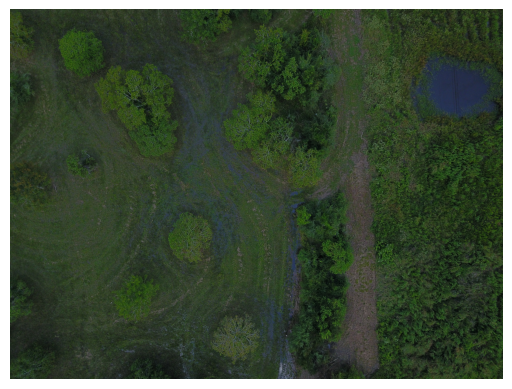

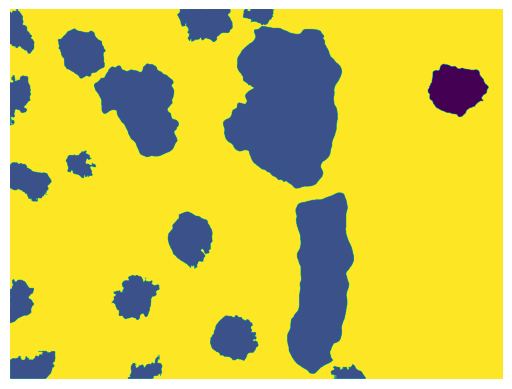

In [78]:
plot_random_image(train_image_folder, train_mask_folder)

---
# Creating data loaders

In [79]:
from torchvision.transforms import v2

data_transformer = v2.Compose([
    v2.Resize((128, 128)),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomRotation(30),
    v2.ToTensor()
])

In [80]:
from torch.utils.data.dataset import Dataset
from PIL import Image

class floodDataset(Dataset):
  def __init__(self, img_path, mask_path, transform = None):
    self.image_paths = sorted([os.path.join(img_path, path) for path in os.listdir(img_path)])[:160]
    self.mask_paths = sorted([os.path.join(mask_path, path) for path in os.listdir(mask_path)])[:160]

    self.transform = transform

  def load_image_pair(self, index):
    image = self.image_paths[index]
    mask = self.mask_paths[index]
    return Image.open(image), Image.open(mask)

  def __getitem__(self, index):
    img, mask = self.load_image_pair(index)

    if self.transform:
      img = self.transform(img)
      mask = self.transform(mask)
      mask = torch.max(mask, dim=0)[0]
      mask *= 255
      return img, mask.long()

  def __len__(self):
    return len(self.image_paths)

In [81]:
train_dataset = floodDataset(train_image_folder, train_mask_folder, data_transformer)

In [82]:
print(len(train_dataset))

160


In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     prefetch_factor=None, # how many batches per epoch?
                                     shuffle=True) # shuffle the data?

# test_dataloader_custom = DataLoader(dataset=test_dataset, # use custom created test Dataset
#                                     batch_size=1,
#                                     num_workers=0,
#                                     shuffle=False) # don't usually need to shuffle testing data

train_dataloader

In [84]:
for img_batch, mask_batch in train_dataloader:
  img = img_batch[0,:,:,:]
  mask = mask_batch[0,:,:]

  print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
  print(f"Image shape: {mask.shape} -> [batch_size, color_channels, height, width]")

  print(mask)

  break

Image shape: torch.Size([3, 128, 128]) -> [batch_size, color_channels, height, width]
Image shape: torch.Size([128, 128]) -> [batch_size, color_channels, height, width]
tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]])


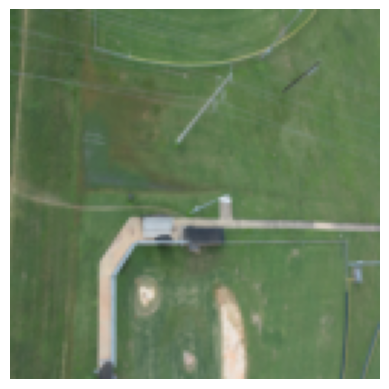

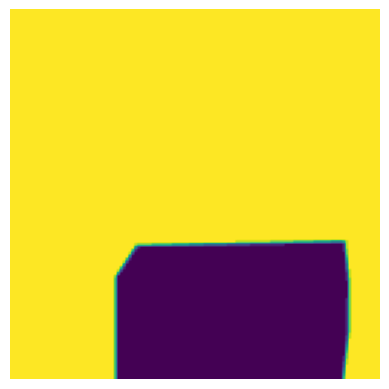

In [85]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(img.permute(1, 2, 0))  # Transpose the image to display it correctly
plt.axis('off')
plt.show()

# Display the mask
plt.imshow(mask)  # Display the mask in grayscale
plt.axis('off')
plt.show()

---
# Class weights

In [86]:
from collections import Counter

def compute_class_weights(dataset, num_classes):
    # Initialize a counter for each class
    class_counts = Counter()

    # Iterate through the dataset and count each class
    for _, mask in dataset:
        class_counts.update(mask.flatten().tolist())

    # Create a numpy array of class counts
    class_counts = np.array([class_counts[i] for i in range(num_classes)])

    # Compute weights as the inverse of class frequency
    class_weights = 1. / class_counts
    class_weights /= class_weights.sum()  # Normalize to sum to 1

    return torch.tensor(class_weights, dtype=torch.float32).to(device)

# num_classes = 10  # Number of classes in your dataset
# class_weights = compute_class_weights(train_dataset, num_classes)

---
# Create UNet

In [87]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.double_conv(x)

In [88]:
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = DoubleConv(in_channels, out_channels)
    self.down = nn.MaxPool2d(2)

  def forward(self, x):
    skip_con = self.double_conv(x)
    down = self.down(skip_con)
    return (down, skip_con)

In [89]:
class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
    self.double_conv = DoubleConv(in_channels, out_channels)

  def forward(self, x, skip_con):
    x = self.up(x)
    x = torch.cat([x, skip_con], dim=1)
    x = self.double_conv(x)
    return x

In [90]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down1 = Down(in_channels, 64)
    self.down2 = Down(64, 128)
    self.down3 = Down(128, 256)
    self.down4 = Down(256, 512)

    self.bottleneck = DoubleConv(512, 1024)

    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)

    self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    down_1, skip_con1 = self.down1(x)
    down_2, skip_con2 = self.down2(down_1)
    down_3, skip_con3 = self.down3(down_2)
    down_4, skip_con4 = self.down4(down_3)

    b = self.bottleneck(down_4)

    up_1 = self.up1(b, skip_con4)
    up_2 = self.up2(up_1, skip_con3)
    up_3 = self.up3(up_2, skip_con2)
    up_4 = self.up4(up_3, skip_con1)

    out = self.out(up_4)

    return out

---
# Dummy run UNET and get summary

In [91]:
model = UNet(input_channels, num_classes).to(device)

In [92]:
img_batch, mask_batch = next(iter(train_dataloader))

img_single, mask_single = img_batch[0].unsqueeze(dim=0).to(device), mask_batch[0].unsqueeze(dim=0).to(device)
print(f"Single image shape: {img_single.shape}\n")
print(f"Single mask shape: {mask_single.shape}\n")

Single image shape: torch.Size([1, 3, 128, 128])

Single mask shape: torch.Size([1, 128, 128])



In [93]:
output = model(img_single)
print(output)

tensor([[[[ 0.1320,  0.1340,  0.1342,  ...,  0.1323,  0.1317,  0.1245],
          [ 0.1334,  0.1341,  0.1369,  ...,  0.1354,  0.1361,  0.1258],
          [ 0.1318,  0.1344,  0.1353,  ...,  0.1350,  0.1355,  0.1280],
          ...,
          [ 0.1294,  0.1327,  0.1351,  ...,  0.1348,  0.1349,  0.1291],
          [ 0.1283,  0.1332,  0.1348,  ...,  0.1348,  0.1336,  0.1305],
          [ 0.1274,  0.1307,  0.1318,  ...,  0.1317,  0.1321,  0.1294]],

         [[ 0.0241,  0.0213,  0.0212,  ...,  0.0194,  0.0172,  0.0173],
          [ 0.0258,  0.0193,  0.0223,  ...,  0.0217,  0.0195,  0.0189],
          [ 0.0265,  0.0197,  0.0212,  ...,  0.0194,  0.0173,  0.0195],
          ...,
          [ 0.0249,  0.0187,  0.0211,  ...,  0.0214,  0.0201,  0.0196],
          [ 0.0222,  0.0160,  0.0187,  ...,  0.0194,  0.0182,  0.0190],
          [ 0.0245,  0.0210,  0.0234,  ...,  0.0204,  0.0191,  0.0197]],

         [[-0.0566, -0.0559, -0.0563,  ..., -0.0566, -0.0600, -0.0605],
          [-0.0590, -0.0580, -

In [94]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 10, 128, 128]         --
├─Down: 1-1                              [1, 64, 64, 64]           --
│    └─DoubleConv: 2-1                   [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         38,720
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
├─Down: 1-2                              [1, 128, 32, 32]          --
│    └─DoubleConv: 2-3                   [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2              [1, 128, 64, 64]          221,440
│    └─MaxPool2d: 2-4                    [1, 128, 32, 32]          --
├─Down: 1-3                              [1, 256, 16, 16]          --
│    └─DoubleConv: 2-5                   [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3              [1, 256, 32, 32]          885,248
│    └─MaxPool2d: 2-6                    [1, 256, 16, 16]          --
├

---
# Train UNet

In [95]:
from tqdm.auto import tqdm
from torch.nn import functional as F

def train_step(model, dataloader, loss_fn, optimizer):
  # Put model in training mode
  model.train()

  # Initiate train loss/accuracy
  train_loss, correct_pixels, total_pixels = 0, 0, 0

  for n_batch, img_mask in enumerate(tqdm(dataloader)):

    img = img_mask[0].to(device)
    mask = img_mask[1].to(device)

    # Forward pass
    mask_pred = model(img)

    # Calculate and accumulate loss
    loss = loss_fn(mask_pred, mask)
    train_loss += loss.item()

    # Reset optimizer to zero gradient
    optimizer.zero_grad()

    # Back prop
    loss.backward()

    # Optimizer step (change params)
    optimizer.step()

    mask_pred_prob = F.softmax(mask_pred, dim=1)
    _, predicted = torch.max(mask_pred_prob, 1)

    correct_pixels += (predicted == mask).sum().item()
    total_pixels += mask.numel()

  train_loss = train_loss / len(dataloader)
  train_acc = correct_pixels / total_pixels

  return train_loss, train_acc

In [96]:
from timeit import default_timer as timer

def train(model, dataloader, loss_fn, optimizer, epochs=5):
  start_time = timer()

  results = {"train_loss": [],
             "train_acc": []}

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model, dataloader, loss_fn, optimizer)

    print(
        f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

  end_time = timer()

  print(f"Total training time: {(end_time - start_time):.3f} seconds")
  return results

In [100]:
model_1 = UNet(input_channels, num_classes).to(device)

loss_fn = nn.CrossEntropyLoss(weight=None)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], profile_memory=True) as prof:
    # Run the training loop
    train(model_1, train_dataloader, loss_fn, optimizer, epochs=10)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2716 | train_acc: 0.3298


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1815 | train_acc: 0.2725


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.2035 | train_acc: 0.1952


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 2.1186 | train_acc: 0.1353


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.8748 | train_acc: 0.1332


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.7538 | train_acc: 0.5404


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.5127 | train_acc: 0.5401


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.4637 | train_acc: 0.5400


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.3787 | train_acc: 0.5493


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.3045 | train_acc: 0.5876
Total training time: 367.909 seconds
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        97.10%      356.894s        97.41%      358.020s        5.967s       0.000us         

(128, 128)
torch.Size([128, 128])
torch.Size([3, 128, 128])


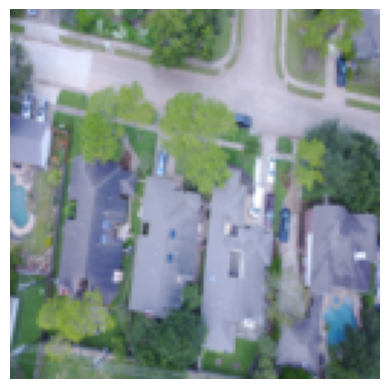

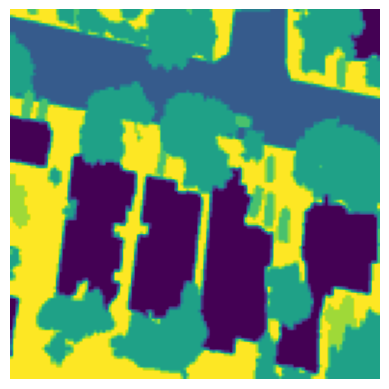

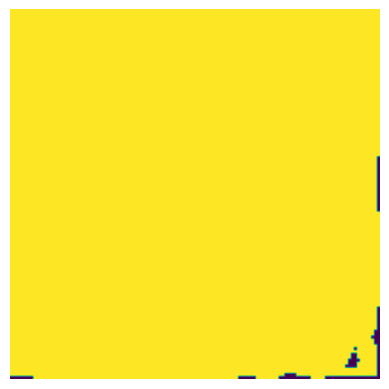

In [101]:
for img_batch, mask_batch in train_dataloader:
  img = img_batch[0,:,:,:]
  mask = mask_batch[0,:,:]

  mask_pred = model_1(img.unsqueeze(dim=0).to(device))
  mask_pred_prob = F.softmax(mask_pred, dim=1)
  _, predicted = torch.max(mask_pred_prob, 1)
  predicted = predicted.squeeze().cpu().numpy()

  print(predicted.shape)
  print(mask.shape)
  print(img.shape)

  plt.imshow(img.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

  plt.imshow(mask)
  plt.axis('off')
  plt.show()

  plt.imshow(predicted)
  plt.axis('off')
  plt.show()

  break

In [99]:
# import os
# import shutil

# # Path to the shared folder (add the shared folder to your drive first)
# shared_drive_path = '/content/gdrive/MyDrive/FloodNet-Supervised_v1.0'

# # Path to your own Google Drive
# my_drive_path = '/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data'

# # Create the destination directory if it doesn't exist
# os.makedirs(my_drive_path, exist_ok=True)

# # Function to copy files and directories
# def copy_files_and_directories(src, dst):
#     if os.path.isdir(src):
#         # If the item is a directory, copy it recursively
#         shutil.copytree(src, dst, dirs_exist_ok=True)
#         print(f"Directory copied: {src} to {dst}")
#     else:
#         # If the item is a file, copy it
#         shutil.copy(src, dst)
#         print(f"File copied: {src} to {dst}")

# # Copy files and directories from shared drive to your own drive
# for item in os.listdir(shared_drive_path):
#     src_path = os.path.join(shared_drive_path, item)
#     dst_path = os.path.join(my_drive_path, item)

#     # Call the function to copy files and directories
#     copy_files_and_directories(src_path, dst_path)

# print("Files and directories copied successfully.")